# Autoencoders for dimensionality reduction and representation learning

### Import common libraries

In [ ]:
# Mount Google Drive and change directory 
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/ColabNotebooks/SACAC-EDA test/solutions

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display format: two decimals
pd.options.display.float_format = '{:,.2f}'.format


We will also reuse the `plotAndColorLatentVariables` function developed during the dimensionality reduction session.

In [159]:
# Define a function that accepts scores (more generally, latent variables) "L" and dataframe "df" as inputs, with optional input "alpha"
def plotAndColorLatentVariables(L, df, alpha = 0.5): 
    I = np.ceil(np.sqrt(df.shape[1])).astype(int)   # Determine the number of rows in the subplot grid
    J = np.ceil(df.shape[1]/I).astype(int)          # Determine the number of columns in the subplot grid
    fig, ax = plt.subplots(I,I, figsize = (20,20))  # Create the subplot grid
    
    for i in range(I):                       # Loop over the rows
        for j in range(I):                   # Loop over the columns
            k = I*i+j-1                      # Compute the index of the subplot
            if k == -1:     # Colour the plot according to the dataframe index
                ax[i,j].scatter(L[:, 0], L[:, 1], alpha = alpha, c=df.index, cmap='viridis')
                ax[i,j].set_title('Index')
                
            elif k <= (df.shape[1]-1):  # Colour the plot according to the dataframe columns
                ax[i,j].scatter(L[:, 0], L[:, 1], alpha = alpha, c=df.iloc[:,k], cmap='viridis')
                ax[i,j].set_title(df.columns[k])

## Case study description

In the previous session, we used the very artificial moons dataset for illustrative purposes, and the ver reall iron ore flotation datasets for practical application. In this session, we will introduce a synthetic, but believable dataset: the mixing tank dataset.

The mixing tank is a commonly used example in process control. Two streams feed the mixing tank. The first has a variable flowrate $ F_0(t) $ and solute concentration $ C_0(t)$, which act as the disturbances to the system. The second is pure solvent ($C_1 = 0$), and the flowrate is manipulated to control the outlet solute concentration. The flowrate out of the tank $ F_2 $ is manipulated to control the liquid level in the tank. 

The system is shown below.

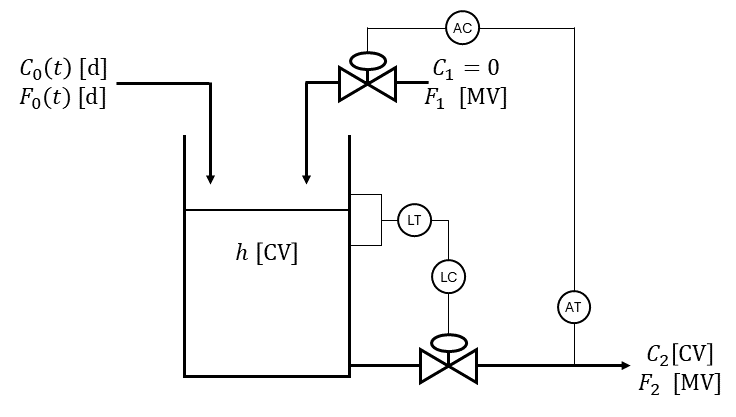

In [160]:
# Show the mixing tank diagram
from IPython.display import display, Image
display(Image(filename='mixingTank.png'))

We load the data from `mixingTank_dataset.csv`, and immediately scale it so that the features have unit variance.

In [161]:
from sklearn.preprocessing import StandardScaler
df_mix = pd.read_csv('../data/mixingTank_dataset.csv')
X = StandardScaler().fit_transform(df_mix)

Let us start by performing PCA and considering the cumulative variance explained.

[0.60608084 0.20052001 0.13532743 0.03832085 0.0177995  0.00195137]


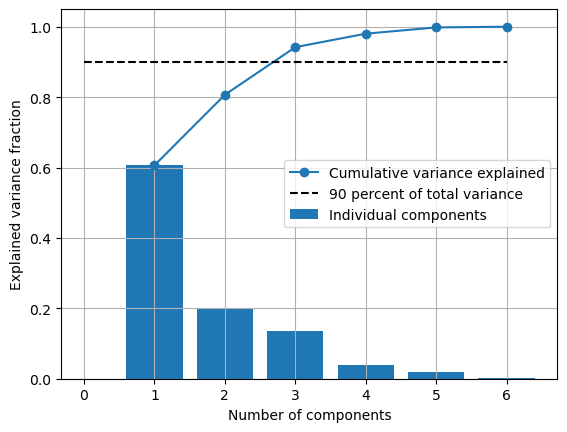

In [162]:
from sklearn.decomposition import PCA
pca = PCA()
T = pca.fit_transform(X)

index=range(1,pca.n_components_+1)  # Used for the x-axis
plt.bar(index, pca.explained_variance_ratio_, label='Individual components')

# Calculate the cumulative explained variance
cumulativeFractionVarianceExplained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(index, cumulativeFractionVarianceExplained, 'o-', label='Cumulative variance explained')

# Additional plot formatting
plt.hlines(0.9, 0, pca.n_components_, color='k', ls='--', label='90 percent of total variance')
plt.xlabel('Number of components')
plt.ylabel('Explained variance fraction')
plt.grid(True)  # Add grid
plt.legend()

print(pca.explained_variance_ratio_)

We see that the first two PCs retain almost 80% of the variance, and the first four PCs retain >95% thereof. Let's visualise the first two PCs, coloured according to the measured variables.

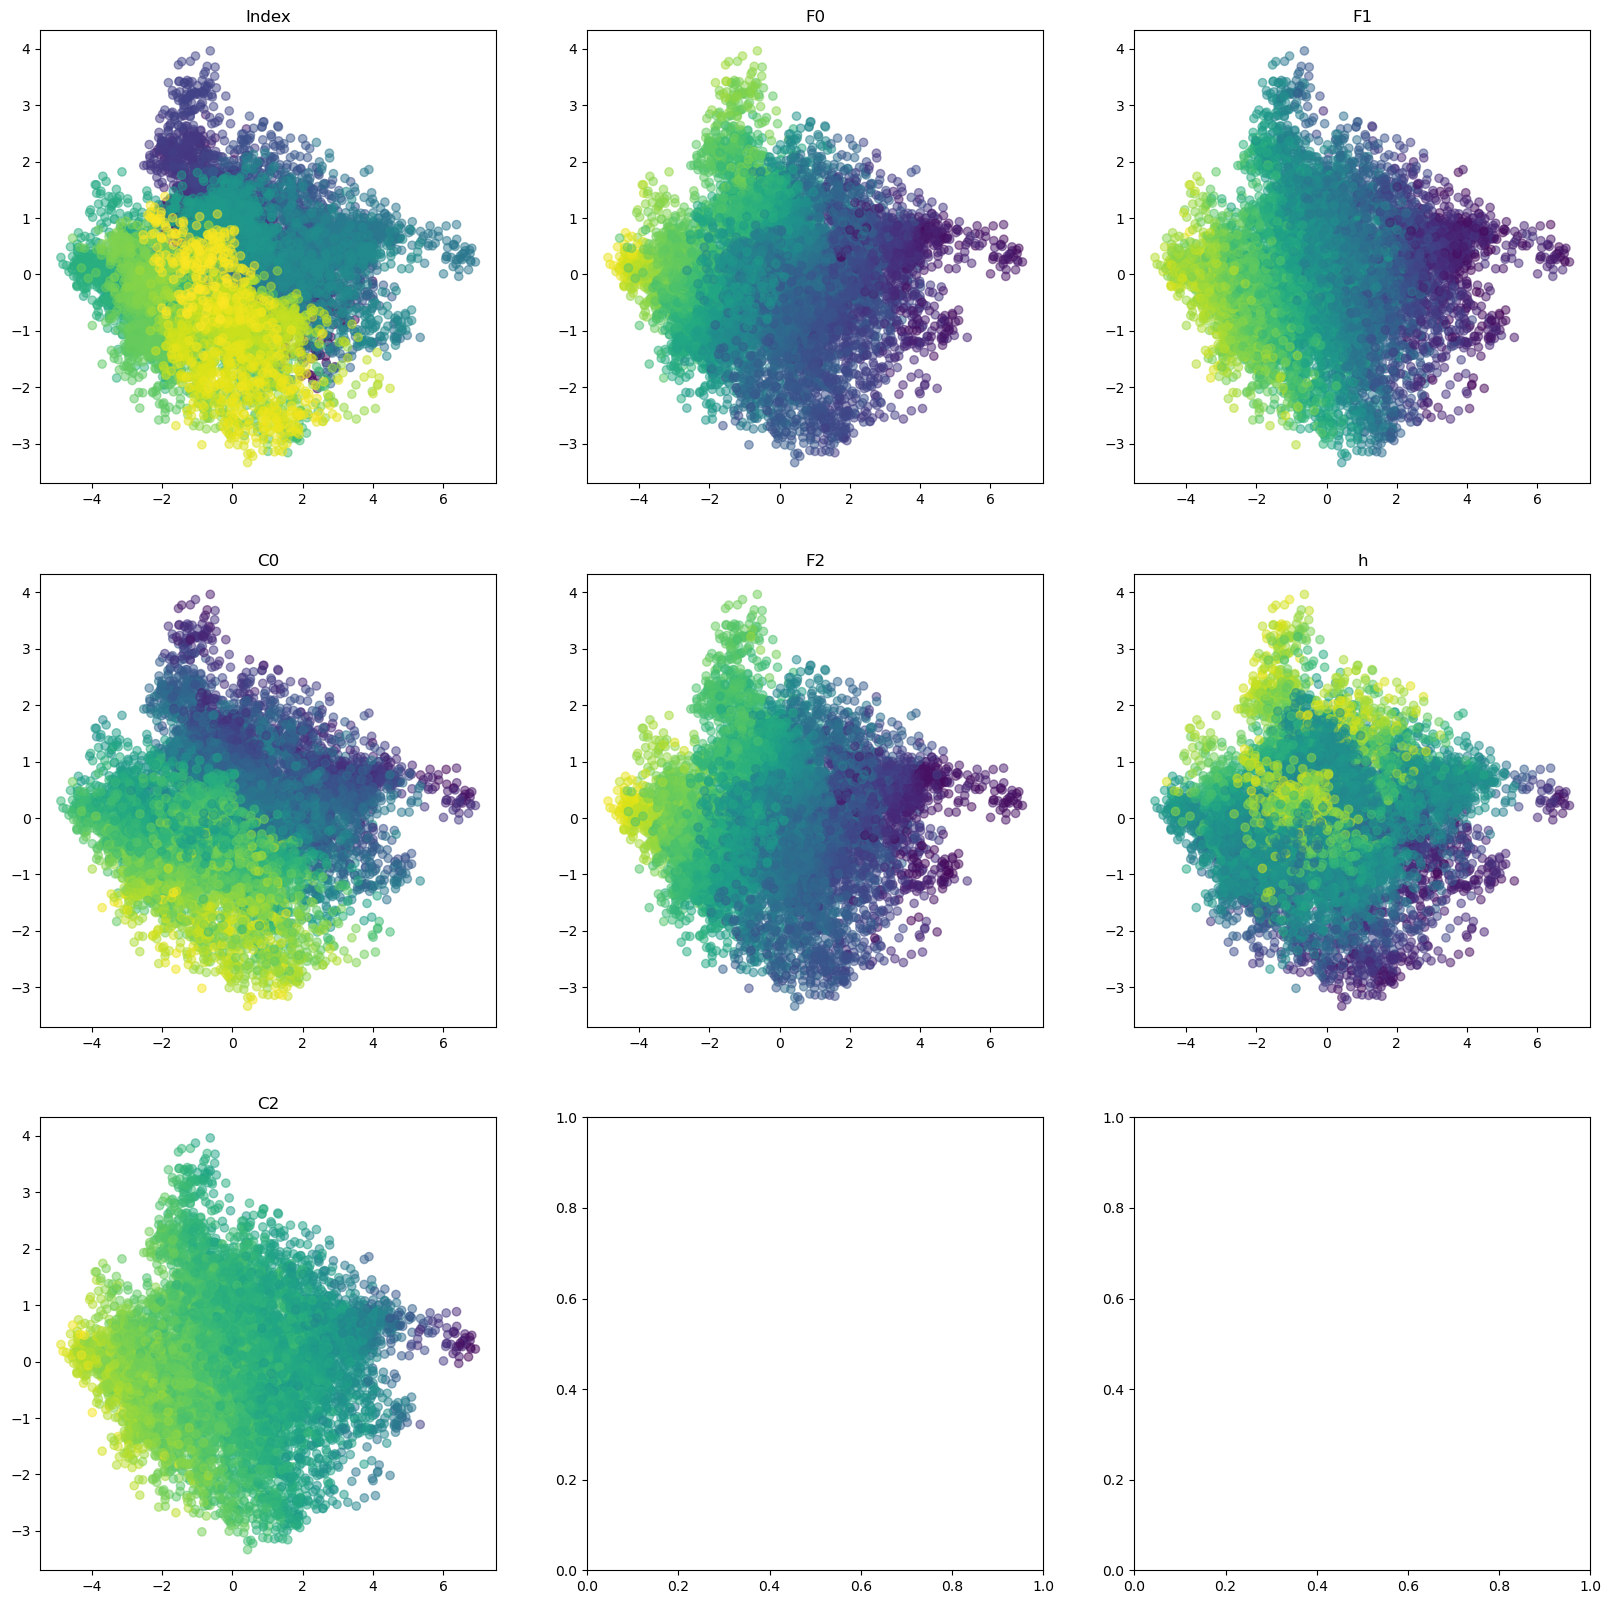

In [163]:
plotAndColorLatentVariables(T, df_mix)

We do see two clusters, which we can attempt to identify using k-means or DBSCAN.

Text(0.5, 1.0, 'DBSCAN')

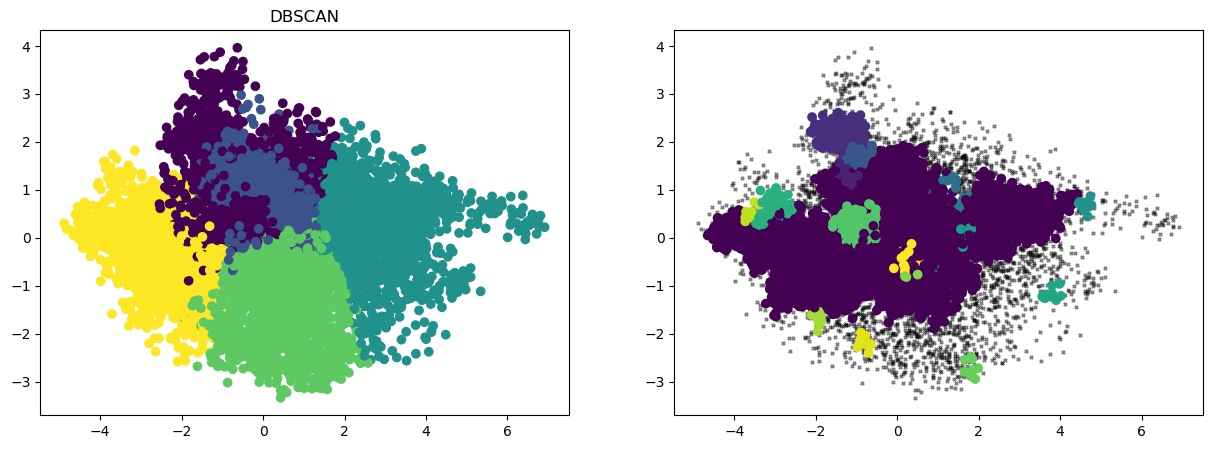

In [164]:
from sklearn.cluster import KMeans, DBSCAN
kmeans = KMeans(n_clusters=5)
kmeans.fit(T[:,:4])

dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(T[:,:4])

fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(T[:, 0], T[:, 1], c=kmeans.labels_, cmap='viridis')
ax[0].set_title('K-means clustering')
ax[1].scatter(T[:, 0], T[:, 1], c='black', alpha=0.5, marker='x', s = 5)
ax[1].scatter(T[dbscan.labels_ != -1, 0], T[dbscan.labels_ != -1, 1], c=dbscan.labels_[dbscan.labels_ != -1], cmap='viridis')
ax[0].set_title('DBSCAN')

Neither clustering algorithm appears to give particularly satisfying results. You may continue to visualise the clusters using the time series data for practice. However, in the section below, we will apply an alternative dimensionality reduction approach

## Neural networks as autoencoders

We will create a neural network with the aim of reconstructing the inputs after passing the inputs through an encoding (i.e., bottleneck) layer consisting of only two features; this type of neural network is often referred to as an autoencoder. The two-dimensional latent variable space must capture the characteristics of the six dimensional input features as effectively as possible. We refer to this as representation learning, that is, learning a lower dimensional representation of the inputs. 

We will use `keras` to construct an autoencoder with three dense hidden layers, a high-level API to the incredibly powerful TensorFlow package. 

* The `keras.Sequential` method is used to stack different layers of a neural network, making for very easy deep learning.
* The `keras.Input` method simply accepts a fixed number of inputs and prepares the connections to subsequent layers
* The `keras.Dense` method creates a dense (fully connected) neural network layer

We use three activation functions:
* The ReLU (rectified linear) activation function is very commonly used in deep learning, enabling non-linearity but negating many problematice effects associated with sigmoid or $\tanh$ activation functions.
* The $\tanh$ activation limits outputs to lie between -1 and 1, which is useful to constrain the encoding layer
* When no activation function is specified, a linear activation function is used, which simply gives the weighted sum of the outputs from the previous layer.

It is common to construct an autoencoder in a symmetric fashion (notice the) number of neurons in the dense layers. There are many different neural network architectures and different types of units (e.g., convolutional filters, recurrent neurons, etc.) and a suitable design should be found using system insight and suitable training / testing / validation data.

Epoch 1/50


631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.8981
Epoch 2/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3778
Epoch 3/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3130
Epoch 4/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2611
Epoch 5/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2327
Epoch 6/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2154
Epoch 7/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2051
Epoch 8/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1935
Epoch 9/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1920
Epoch 10/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1819
Epoch 11/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1750
Epoch 12/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1710
Epoch 13/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1684
Epoch 14/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1677
Epoch 15/50
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1619


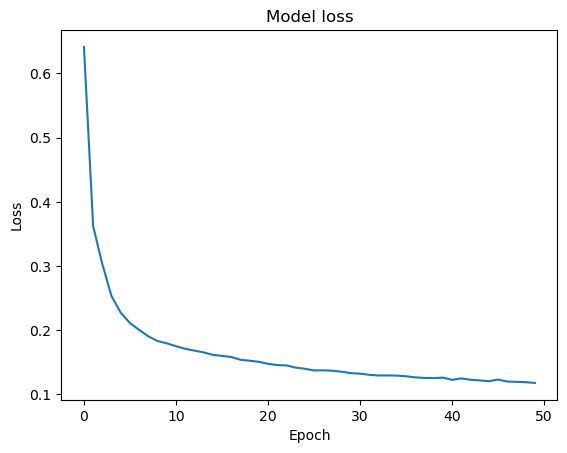

In [165]:
import keras
nLayers_1 = 16  # Number of neurons in the first layer
nLayers_2 = 8  # Number of neurons in the second layer

# We define the encoder and decoder separately. The encoder can later be used to calculate the latent variables.
aeEncoder = keras.Sequential([
    keras.layers.Input(shape=(T[:,:4].shape[1],)),    # Input layer
    keras.layers.Dense(nLayers_1, activation='relu'),  # First hidden layer with ReLU activation function
    keras.layers.Dense(nLayers_2, activation='relu'),  # Second hidden layer with ReLU activation function
    keras.layers.Dense(2, activation='tanh'),   # Encoding layer, with tanh activation function to limit the latent variables between [-1,1]
])

aeDecoder = keras.Sequential([
    keras.layers.Dense(nLayers_2, activation='relu'),   # Second decoding layer with ReLU activation function
    keras.layers.Dense(nLayers_1, activation='relu'),   # Third decoding layer with ReLU activation function
    keras.layers.Dense(T[:,:4].shape[1])  # Output layer, with linear activation function to achieve any possible output value
])

# Autoencoder (combined model)
autoencoder = keras.Sequential([
    aeEncoder,
    aeDecoder
])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history=autoencoder.fit(T[:,:4], T[:,:4], epochs=50, batch_size=16)

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


  1/316 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


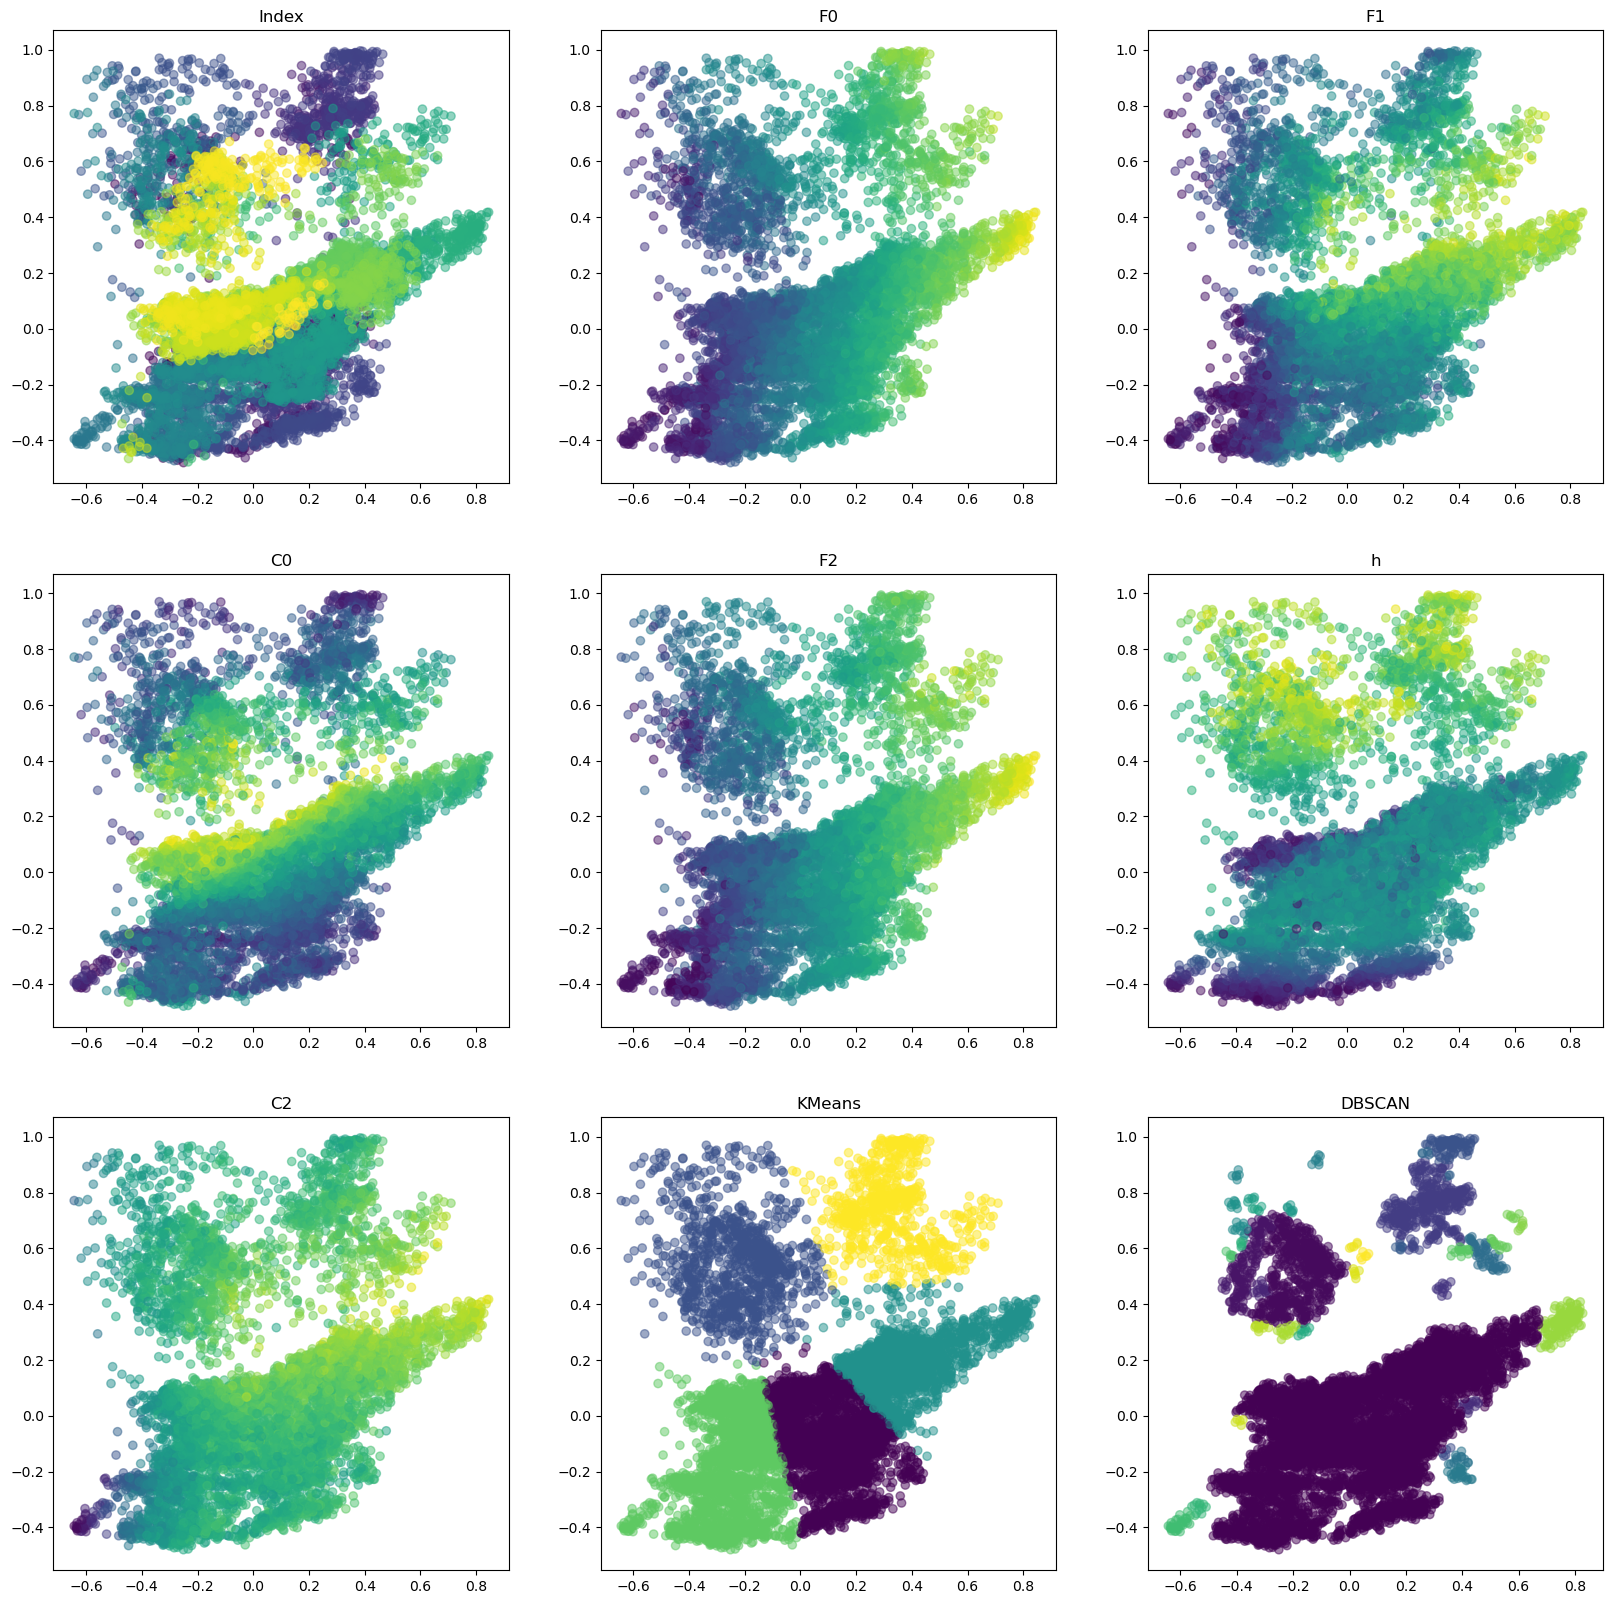

In [166]:
L = aeEncoder.predict(T[:,:4])

kmeans = KMeans(n_clusters=5)
kmeans.fit(L)

dbscan = DBSCAN(eps=0.02, min_samples=5)
dbscan.fit(L)

df_mix_clustered = df_mix.copy()
df_mix_clustered['KMeans'] = kmeans.labels_
df_mix_clustered['DBSCAN'] = dbscan.labels_
df_mix_clustered.loc[df_mix_clustered['DBSCAN'] == -1, 'DBSCAN'] = np.NaN

plotAndColorLatentVariables(L, df_mix_clustered, alpha=0.5)

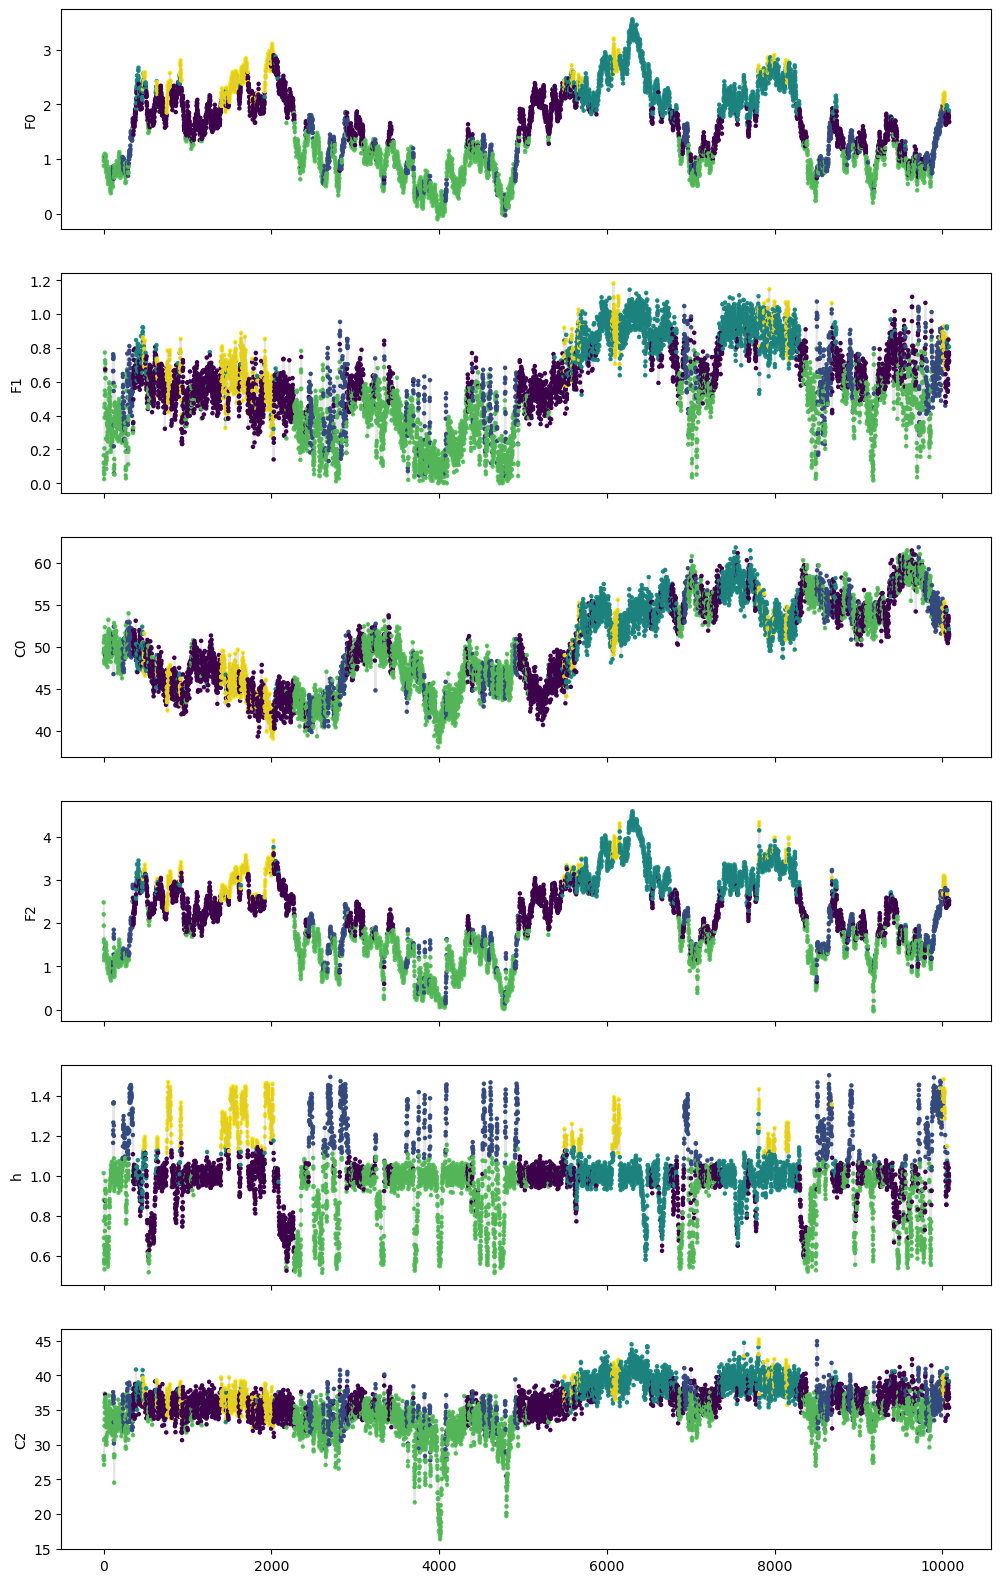

In [167]:
# Select a subset of features to visualize
selected = ['F0', 'F1', 'C0', 'F2', 'h', 'C2']

fig,ax = plt.subplots(len(selected), 1, figsize=(12,20), sharex= True)
for (i, col) in enumerate(selected):
    ax[i].plot(df_mix.index, df_mix[col], 'k', alpha = 0.1)       # Line plot of features
    ax[i].scatter(df_mix.index, df_mix[col], s = 5, c=df_mix_clustered['KMeans']) # Scatter plot of features colored by cluster
    ax[i].set_ylabel(col)


While the `keras` API simplifies the implementation of neural networks, many challenges remain: neural networks are difficult to design and are prone to overfitting, particularly on smaller datasets. Modern architectures (e.g., LSTMs) hold promise for time series analysis.